In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.ndimage

def imshow(img, ax=None, title="", bgr=True):
    # since plt and cv2 have different RGB sorting
    if bgr:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if ax == None:
        plt.imshow(img.astype(np.uint8))
        plt.axis("off")
        plt.title(title)
    else:
        ax.imshow(img.astype(np.uint8))
        ax.set_axis_off()
        ax.set_title(title)
        
plt.rcParams["figure.figsize"] = (12,6)

# Images

Denote a image (matrix of integer values) as $I$  
For gray-scale images, $I_{m\times n}$; where $I(i,j)$ is called intensity  
For color images, $I_{m\times n\times \{1,2,3\}}$, 3 for RGB values

Alternatively, think of a grayscale image as a mapping $I:\mathbb N^2 \rightarrow \{0,1,...,255\}$, i.e. position $(i,j)\rightarrow$ gray-scale, where 0 is black, 255 is white

__Example__
For image $I(i,j)$; $I(i,j)+50$ lighten the image, $I(i,-j)$ rotate the image horizontally

In [2]:
# load as gray scale
img_gray = cv2.imread("./assets/yurina.jpg", cv2.IMREAD_GRAYSCALE)
# load as colored
img = cv2.imread("./assets/yurina.jpg")

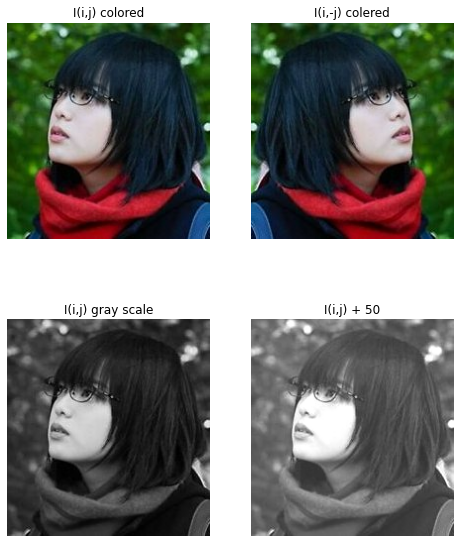

In [3]:
img1 = cv2.add(img_gray, 50)
img2 = cv2.flip(img, 1)

fig, axs = plt.subplots(2, 2, figsize = (8, 10))
imshow(img, axs[0][0], "I(i,j) colored")
imshow(img2, axs[0][1], "I(i,-j) colered")
imshow(img_gray, axs[1][0], "I(i,j) gray scale")
imshow(img1, axs[1][1], "I(i,j) + 50")

# Image filters
Modify the pixels in an image based on some function of a local neighborhood of each pixel  

Can be used to enhance (denoise), detect patterns (matching), extract information (texture, edges)


### Boundary Effects
Consider the boundary of the image, there are three modes: `full, same, valid`  

# Correlation
Given a image $I$, the filtered image is 
$$G(i,j) = \sum_{u=-k}^k \sum_{v=-k}^k F(u,v)\cdot I(i+u, j + v)$$
The entries of the weight __kernel__ of __mask__ $F(u,v)$ are often called the __filter coefficients__  
Denote this __correlation__ operator $F\otimes I$

OpenCV `cv2.filter2d`

We can also write correlation in a more compact form using vectors, i.e.

Let $\mathbf f = F$ be the kernel matrix, $\mathbf t_{ij} = T_{i,j}(I_{\{i-k, i+k\} \times \{j-k, j+k\}})$ be the matrix of the image centered at $(i,j)$ and of size $2k + 1$, then $G(i,j)=\mathbf f\cdot \mathbf t_{ij}$

And the full image 
$$\mathbf G_{m\times n} = 
\begin{bmatrix}
G(0,0) &G(0, 1)&... &G(0, n) \\
G(1,0) &G(1, 1)&... &G(1, n) \\
... &...&... &... \\
G(m,0) &G(m, 1)&... &G(m, n) \\
\end{bmatrix}$$

# Example of Filter kernels

### Unchanged
\begin{bmatrix}
0 &0 &0 \\
0 &1 &0 \\
0 &0 &0
\end{bmatrix}
### shifting to the left by 1px
\begin{bmatrix}
0 &0 &0 \\
0 &0 &1 \\
0 &0 &0
\end{bmatrix}

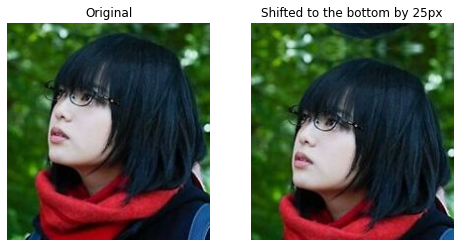

In [4]:
k_shifting = np.zeros((50,50))
k_shifting[0, 25] = 1
img_shifting = cv2.filter2D(img, -1, k_shifting)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
imshow(img, axs[0], "Original")
imshow(img_shifting, axs[1], "Shifted to the bottom by 25px")

## Sharpening
$$M1 = \begin{bmatrix}
0 &0 &0 \\
0 &2 &0 \\
0 &0 &0
\end{bmatrix} - 
\frac{1}{9}
\begin{bmatrix}
1 &1 &1 \\
1 &1 &1 \\
1 &1 &1
\end{bmatrix}$$
To enhance the effect, using a larger center value
$$M2 = \begin{bmatrix}
0 &0 &0 \\
0 &5 &0 \\
0 &0 &0
\end{bmatrix} - 
\frac{4}{9}
\begin{bmatrix}
1 &1 &1 \\
1 &1 &1 \\
1 &1 &1
\end{bmatrix}$$
If we enlarge the matrix to 5
$$M3 = \vec 0_{5\times 5} + [5]_{center} - 
\frac{4}{25}
J_{5\times 5}$$

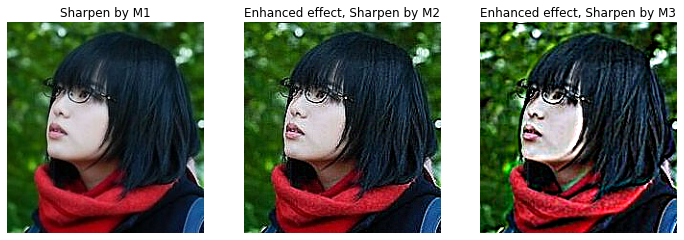

In [5]:
k_sharp_3_2 = np.zeros((3,3), np.float32)
k_sharp_3_2[1,1] = 2
k_sharp_3_2 = k_sharp_3_2 - np.ones((3,3), np.float32) / 9
img_sharp_3_2 = cv2.filter2D(img, -1, k_sharp_3_2)

k_sharp_3_5 = np.zeros((3,3), np.float32)
k_sharp_3_5[1,1] = 5
k_sharp_3_5 = k_sharp_3_5 - np.ones((3,3), np.float32) *4 / 9
img_sharp_3_5 = cv2.filter2D(img, -1, k_sharp_3_5)

k_sharp_5_5 = np.zeros((5,5), np.float32)
k_sharp_5_5[1,1] = 5
k_sharp_5_5 = k_sharp_5_5 - np.ones((5,5), np.float32) *4 / 25
img_sharp_5_5 = cv2.filter2D(img, -1, k_sharp_5_5)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
imshow(img_sharp_3_2, axs[0], "Sharpen by M1")
imshow(img_sharp_3_5, axs[1], "Enhanced effect, Sharpen by M2")
imshow(img_sharp_5_5, axs[2], "Enhanced effect, Sharpen by M3")

# Smoothing

## Smoothing 1: Moving Averaging filter
Simplest thing is to replace each pixel by the __average__ of its neighbors, i.e. 
$F$ will be a $(2k+1)^{-2} J_{(2k+1)\times (2k+1)}$ matrix 

__Assumption__ neighboring pixels are similar, and noise is independent of pixels. 

For example, the following uses $\frac{1}{9}J_{3\times 3}$ and $\frac{1}{25}J_{5\times 5}$, note that the matrix should add up to one, hence the image is normalized. 

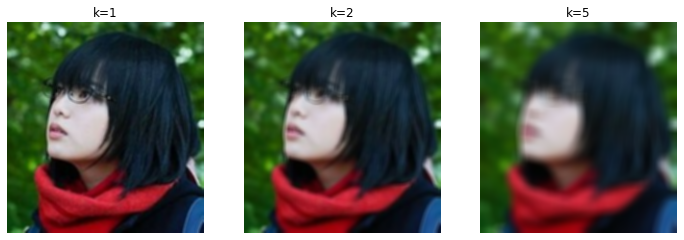

In [6]:
k_3 = np.ones((3,3),np.float32) / 9
img_3 = cv2.filter2D(img,-1,k_3)

k_5 = np.ones((5,5),np.float32) / 25
img_5 = cv2.filter2D(img,-1,k_5)

k_11 = np.ones((11,11),np.float32) / 121
img_11 = cv2.filter2D(img,-1,k_11)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
imshow(img_3, axs[0], "k=1")
imshow(img_5, axs[1], "k=2")
imshow(img_11, axs[2], "k=5")

## Smoothing 2: Gaussian Filter
When we want nearest neighboring pixels to have the most influence on the output, which can removes high-frequency components from the image (low-pass filter).

For example, 
$$F = \frac{1}{16}
\begin{bmatrix}
1 &2 &1 \\
2 &4 &2 \\
1 &2 &1
\end{bmatrix}$$

The Gaussian kernel is an approximation of a 2d Gaussian function 
$$h_{\sigma}(u,v)=\frac{1}{2\pi \sigma^2}\exp(-\frac{u^2 + v^2}{\sigma^2})$$

In [7]:
# simple version of a square Gaussian function
# this filter is equivalent to cv2.GaussianBlur(img, (size, size), sigma)
def Gaussian(size, sigma):
    coef = 1 / (2 * math.pi * sigma **2)
    gaus = np.fromfunction(lambda x, y: coef * math.e \
                           ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    return gaus / np.sum(gaus)

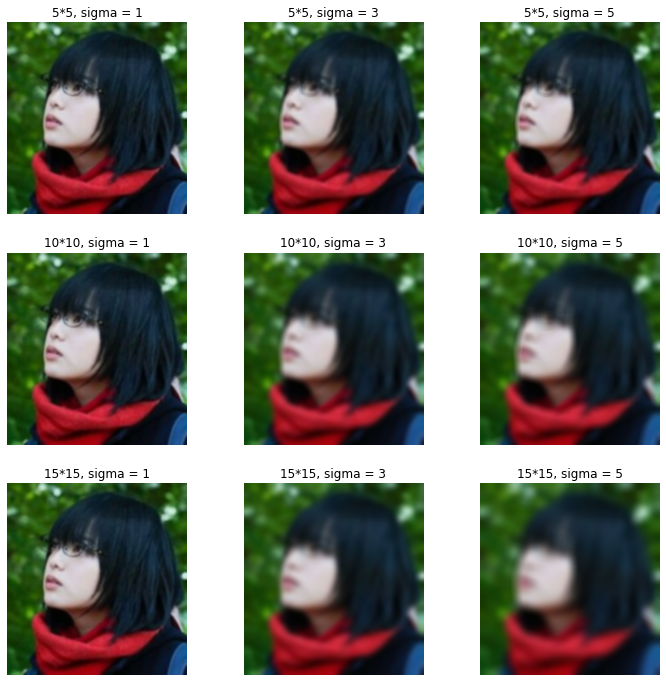

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for r in range(3):
    for c in range(3):
        size = 5 * (r + 1)
        sigma = 2 * c + 1
        title = str(size) + "*" + str(size)+", sigma = " + str(sigma)
        imshow(cv2.filter2D(img, -1, Gaussian(size, sigma)), axs[r][c], title)

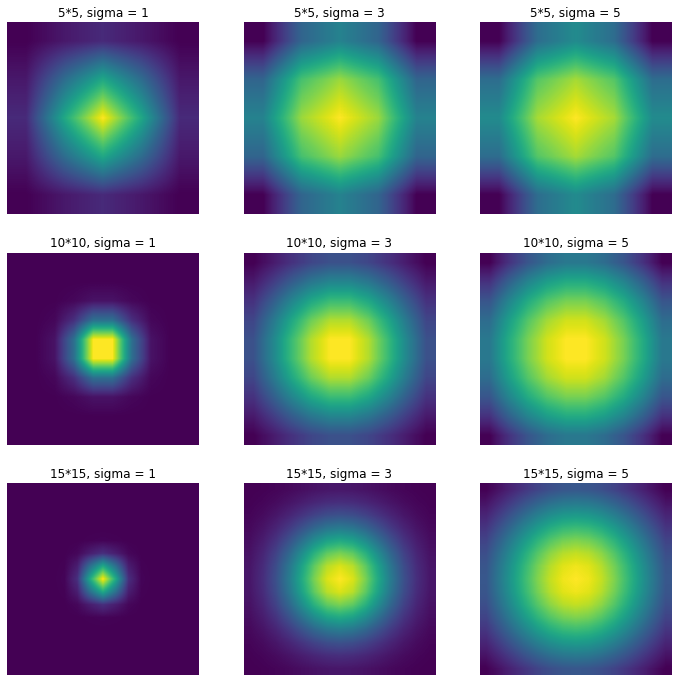

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for r in range(3):
    for c in range(3):
        size = 5 * (r + 1)
        sigma = 2 * c + 1
        title = str(size) + "*" + str(size)+", sigma = " + str(sigma)
        axs[r][c].imshow(Gaussian(size,sigma), interpolation='bilinear')
        axs[r][c].set_title(title)
        axs[r][c].set_axis_off()

A more general form of the Gaussian kernel is obtained by the multi-variante Gaussian distribution $\mathcal N(\mu, \Sigma)$, where 
$$P(\vec x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp(-\frac{(\vec x - \mu)^T \Sigma^{-1}(\vec x - \mu)}{2})$$

## Properties of Smoothing
- All values are positive
- The kernel sums up to 1 to prevent re-scaling of the image
- Remove high-frequency components (edges); low-pass filter

### Filtering image to find image crop (Normalized cross-correlation)
Let $\mathbf f$ be a image crop, $\mathbf t$ be the original image, then $G(i,j) = \frac{\mathbf f^T \mathbf t_{ij}}{\|\mathbf f^T \|\|\mathbf t_{ij}\|}$ is the "normalized score" $(0\sim 1)$, where $1$ indicates the matching

Consider the following image crop

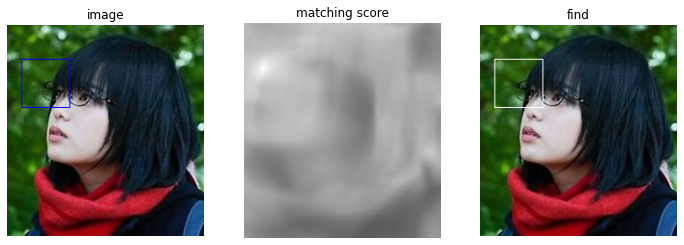

In [10]:
img_crop = img.copy()
cv2.rectangle(img_crop, (15, 35), (65, 85), 255)

crop = img[35: 85, 15: 65]  
fig, axs = plt.subplots(1, 3, figsize=(12,4));
imshow(img_crop, axs[0], "image")

matched = cv2.matchTemplate(img, crop, cv2.TM_CCORR_NORMED)
imshow(matched * 255, axs[1], "matching score")

loc = np.where(matched == 1) 
# Draw a rectangle around the matched region. 
for pt in zip(*loc[::-1]): 
    cv2.rectangle(img_crop, pt, (pt[0] + 50, pt[1] + 50), (255,255,255)) 

imshow(img_crop, axs[2], "find")

# Convolution

A convolution $F*I$ is equivalent to flip $F$ along the diagonal and apply correlation. i.e. 
$$G(i,j) = \sum_{u=-k}^k\sum_{v={-k}}^k F(u,v)\cdot I(i-u, j-v)$$

Obviously, for a symmetric filter matrix, convolution and correlation will do the same

Convolution is the natural linear feature, and it is  
- commutative $f*g = g*f$, 
- associative $f*(g*h) = (f*g)*h$, 
- distributive $f*(g+h)=f*g + f*h$
- associative with scalar $\lambda (f*g)=(\lambda f)*g$
- The Fourier transform of two convolved images is the product of their individual Fourier transforms $\mathcal F(f*g) =\mathcal F(f)\cdot \mathcal F(g)$

# Separable Filters
A convolution filter is separable if it can be written as the outer product of two 1D filters. i.e. $F = vh^T$, then $F*I = v*(h*I)$ by associative property. 

__Example__ 
$$ k^{-2} J = k^{-1}[1 \:1 \:... \:1]^T k^{-1}[1 \:1 \:... \:1]$$

$$ \frac{1}{16}
\begin{bmatrix}
1 &2 &1 \\
2 &4 &2 \\
1 &2 &1
\end{bmatrix} 
= \frac{1}{4}
\begin{bmatrix}
1\\ 2\\ 1
\end{bmatrix}
\frac{1}{4}
\begin{bmatrix}
1&2&1
\end{bmatrix}$$

$$
\begin{bmatrix}
-1 &0 &1 \\
-2 &0 &2 \\
-1 &0 &1
\end{bmatrix} 
= 
\begin{bmatrix}
1\\ 2\\ 1
\end{bmatrix}
\begin{bmatrix}
-1&0&1
\end{bmatrix}$$

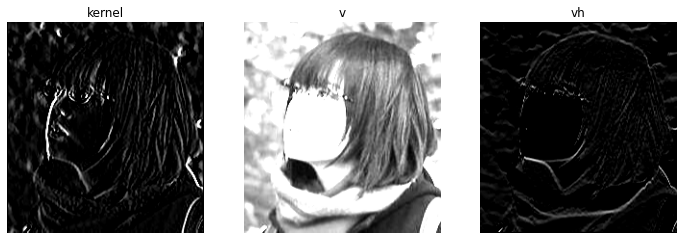

In [11]:
kernel = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]])
kernel_h = np.array([1, 0, -1])
kernel_v = np.array([[1], [2], [1]])
img_k = cv2.filter2D(img_gray, -1, kernel, delta=0)
img_k1 = cv2.filter2D(img_gray, -1, kernel_v, delta=0)
img_k2 = cv2.filter2D(img_k1, -1, kernel_h, delta=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
imshow(img_k, axs[0], "kernel")
imshow(img_k1, axs[1], "v")
imshow(img_k2, axs[2], "vh")

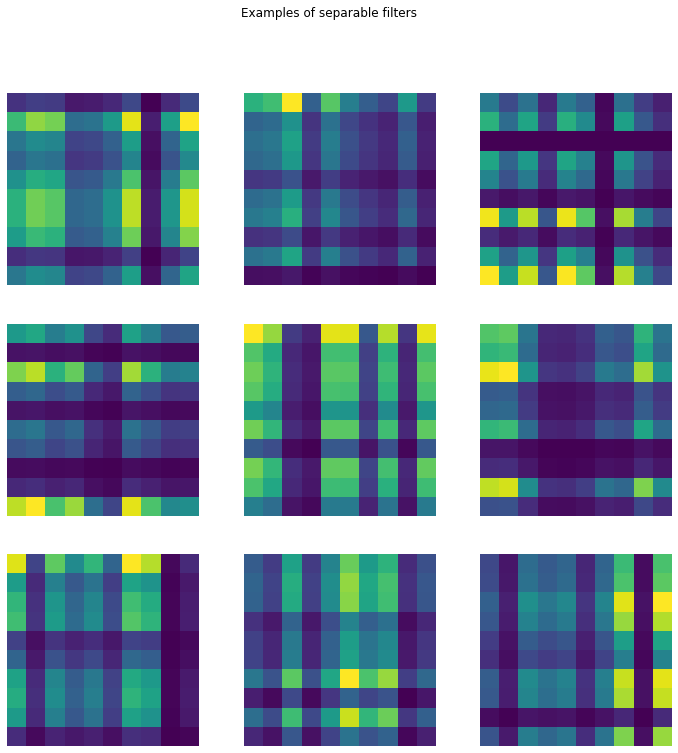

In [12]:
fig, axs = plt.subplots(3,3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        a = np.random.rand(1, 10)
        b = np.random.rand(10, 1)
        axs[i][j].imshow(a * b)
        axs[i][j].set_axis_off()
fig.suptitle("Examples of separable filters");

## How to tell is separable
__Quickcheck__ it has rank 1 (otherwise it cannot be written as 2 1D array)

__Singular value decomposition (SVD)__ decompose by $F = \mathbf U \Sigma \mathbf V^T = \sum_i \sigma_i u_i v_i^T$
with $\Sigma = diag(\sigma_i)$ if only one singular value $\sigma_i$ is non-zero, then it is separable and $\sqrt{\sigma_1}\mathbf u, \sqrt{\sigma_1} \mathbf v_1^T$ are the 1D filters